In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as st
import tskit
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg")
import sparg

In [2]:
# set seed
np.random.seed(10)


# load and filter the tree sequence
cutoff = 2000
ts = tskit.load("../../simulations/UniformStartTwoDims/outputs/original/S025_I1_R2_W100_D2/rep5_S025_I1_R2_W100_D2.trees")

locations = ts.tables.individuals.location
x = locations[::3]
y = locations[1::3]

samples = list(np.random.choice(ts.samples(), 500, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_final, maps_final = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)
ts_chopped = sparg.chop_arg(ts=ts_final, time=cutoff)

In [3]:
locations = ts.tables.individuals.location
x_locations = locations[::3]
y_locations = locations[1::3]
center_of_samples = (np.mean(x_locations), np.mean(y_locations))

### Error and variances of methods

The midpoint method does not estimate variance; for all other methods we use the theoretical dispersal rate matrix rather than the estimated dispersal rate matrix to ensure consistency between the methods.

In [4]:
random_ancestors = pd.read_csv("random_ancestors.csv")

In [5]:
#random_ancestors["midpoint_error_1"] = random_ancestors["true_location_1"] - random_ancestors["midpoint_estimated_location_1"]
#random_ancestors["midpoint_abs_error_1"] = abs(random_ancestors["midpoint_error_1"])
#random_ancestors["midpoint_abs_error"] = np.sqrt(random_ancestors["midpoint_abs_error_0"]**2+random_ancestors["midpoint_abs_error_1"]**2)

#random_ancestors["arg_error_1"] = random_ancestors["true_location_1"] - random_ancestors["arg_estimated_location_1"]
#random_ancestors["arg_abs_error_1"] = abs(random_ancestors["arg_error_1"])
#random_ancestors["arg_abs_error"] = np.sqrt(random_ancestors["arg_abs_error_0"]**2+random_ancestors["arg_abs_error_1"]**2)

#random_ancestors["window_0_error_1"] = random_ancestors["true_location_1"] - random_ancestors["window_0_estimated_location_1"]
#random_ancestors["window_0_abs_error_1"] = abs(random_ancestors["window_0_error_1"])
#random_ancestors["window_0_abs_error"] = np.sqrt(random_ancestors["window_0_abs_error_0"]**2+random_ancestors["window_0_abs_error_1"]**2)

#random_ancestors["window_100_error_1"] = random_ancestors["true_location_1"] - random_ancestors["window_100_estimated_location_1"]
#random_ancestors["window_100_abs_error_1"] = abs(random_ancestors["window_100_error_1"])
#random_ancestors["window_100_abs_error"] = np.sqrt(random_ancestors["window_100_abs_error_0"]**2+random_ancestors["window_100_abs_error_1"]**2)

#random_ancestors.to_csv("random_ancestors.csv")

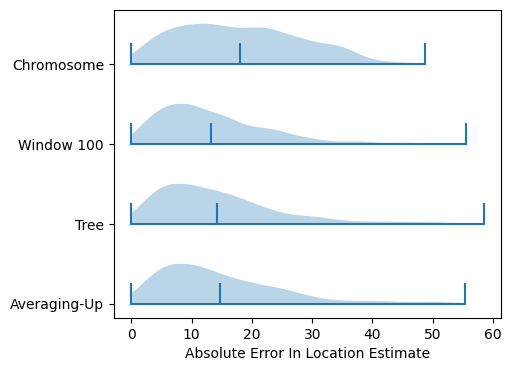

In [5]:
plt.figure(figsize=(5,4))
plt.violinplot([
    random_ancestors["midpoint_abs_error"],
    random_ancestors["window_0_abs_error"],
    random_ancestors["window_100_abs_error"],
    random_ancestors["arg_abs_error"]
], showmeans=True, vert=False, side="high", widths=1)
plt.yticks([1,2,3,4], ["Averaging-Up", "Tree", "Window 100", "Chromosome"])
plt.xlabel("Absolute Error In Location Estimate")
plt.savefig("subfigures/Fig6_Accuracy.svg")
plt.show()

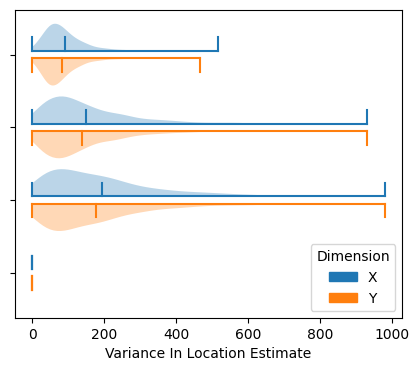

In [29]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

gap = 0.05
plt.figure(figsize=(5,4))
plt.violinplot([
    [0 for i in range(random_ancestors.shape[0])],
    random_ancestors["window_0_variance_in_estimated_location_0"],
    random_ancestors["window_100_variance_in_estimated_location_0"],
    random_ancestors["arg_variance_in_estimated_location_0"],
], showmeans=True, vert=False, side="high", widths=0.75, positions=[1+gap,2+gap,3+gap,4+gap])
plt.violinplot([
    [0 for i in range(random_ancestors.shape[0])],
    random_ancestors["window_0_variance_in_estimated_location_1"],
    random_ancestors["window_100_variance_in_estimated_location_1"],
    random_ancestors["arg_variance_in_estimated_location_1"]
], showmeans=True, vert=False, side="low", widths=0.75, positions=[1-gap,2-gap,3-gap,4-gap])

patches = []
for i,n in enumerate(["X", "Y"]):
    patches.append(mpatches.Patch(color=colors[i], label=n))
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend(patches)

plt.yticks([4,3,2,1], ["", "", "", ""])
plt.legend(title="Dimension", handles=handles, loc="lower right")
plt.xlabel("Variance In Location Estimate")
plt.savefig("subfigures/Fig6_Variance.svg")
plt.show()

### Why are we getting worse error when using the full ARG compared to just the local tree?

This is very surprising as the full ARG shoud have more information than the local trees. The following plot shows that the ARG method is pulling ancestors too quickly into the center.

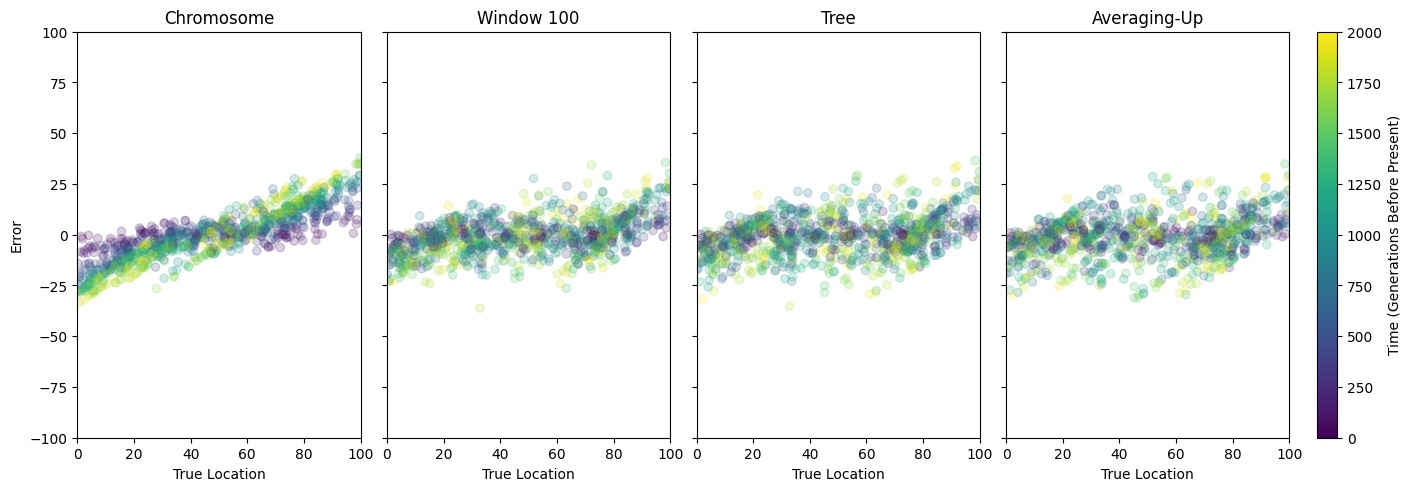

In [23]:
fig, ((ax2, ax1, ax0, ax3)) = plt.subplots(nrows=1, ncols=4, layout="constrained")

ax0.scatter(random_ancestors["true_location_0"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_xlim([0, 100])
ax0.set_ylim([-100, 100])
ax0.set_title("Tree")
ax0.set_xlabel("True Location")
ax0.yaxis.set_ticklabels([])
ax1.scatter(random_ancestors["true_location_0"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_xlim([0, 100])
ax1.set_ylim([-100, 100])
ax1.set_title("Window 100")
ax1.set_xlabel("True Location")
ax1.yaxis.set_ticklabels([])
ax2.scatter(random_ancestors["true_location_0"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_xlim([0, 100])
ax2.set_ylim([-100, 100])
ax2.set_title("Chromosome")
ax2.set_xlabel("True Location")
ax2.set_ylabel("Error")
midpoint = ax3.scatter(random_ancestors["true_location_0"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_xlim([0, 100])
ax3.set_ylim([-100, 100])
ax3.set_title("Averaging-Up")
ax3.set_xlabel("True Location")
ax3.yaxis.set_ticklabels([])

colorbar = fig.colorbar(midpoint, ax=ax3, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)
plt.savefig("subfigures/S_LocationBias.svg")
plt.show()

In [7]:
random_ancestors["midpoint_central"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["midpoint_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["midpoint_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["arg_central"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["arg_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["arg_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["window_0_central"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["window_0_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_0_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["window_100_central"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["window_100_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_100_estimated_location_1"] - center_of_samples[1])**2)

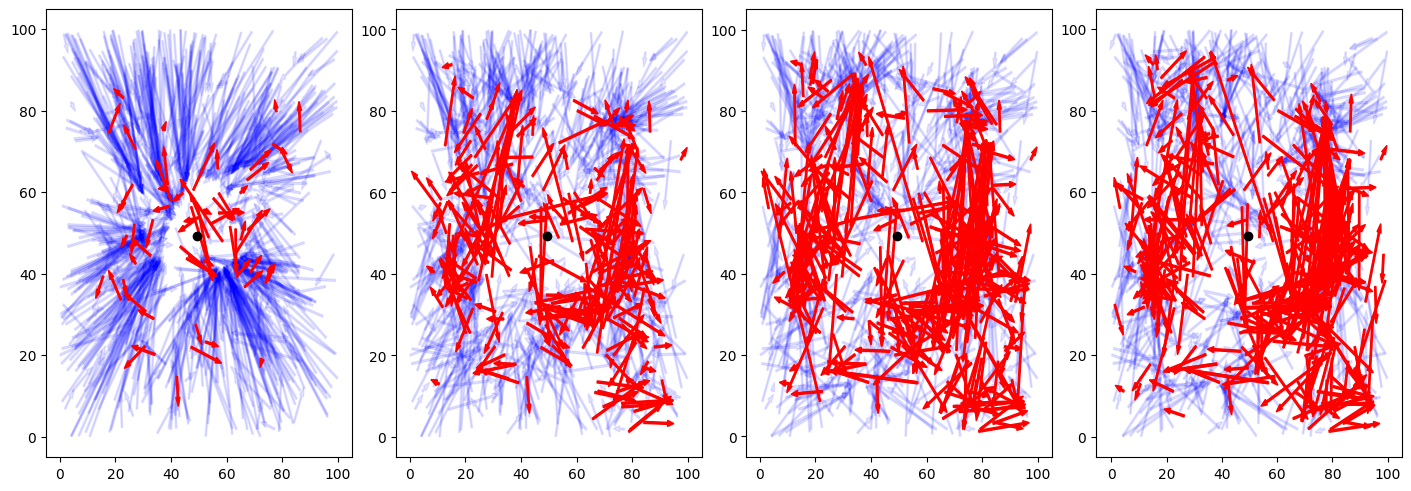

In [104]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, layout="constrained")

for i,row in random_ancestors.iterrows():
    if row["arg_central"]:
        ax0.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["arg_estimated_location_0"]-row["true_location_0"],
            row["arg_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="red",
            zorder=1
        )
    else:
        ax0.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["arg_estimated_location_0"]-row["true_location_0"],
            row["arg_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="blue",
            alpha=0.1,
            zorder=0
        )
ax0.scatter(center_of_samples[0], center_of_samples[1], color="black", zorder=2)

for i,row in random_ancestors.iterrows():
    if row["window_100_central"]:
        ax1.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["window_100_estimated_location_0"]-row["true_location_0"],
            row["window_100_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="red",
            zorder=1
        )
    else:
        ax1.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["window_100_estimated_location_0"]-row["true_location_0"],
            row["window_100_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="blue",
            alpha=0.1,
            zorder=0
        )
ax1.scatter(center_of_samples[0], center_of_samples[1], color="black", zorder=2)

for i,row in random_ancestors.iterrows():
    if row["window_0_central"]:
        ax2.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["window_0_estimated_location_0"]-row["true_location_0"],
            row["window_0_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="red",
            zorder=1
        )
    else:
        ax2.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["window_0_estimated_location_0"]-row["true_location_0"],
            row["window_0_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="blue",
            alpha=0.1,
            zorder=0
        )
ax2.scatter(center_of_samples[0], center_of_samples[1], color="black", zorder=2)

for i,row in random_ancestors.iterrows():
    if row["midpoint_central"]:
        ax3.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["midpoint_estimated_location_0"]-row["true_location_0"],
            row["midpoint_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="red",
            zorder=1
        )
    else:
        ax3.arrow(
            row["true_location_0"],
            row["true_location_1"],
            row["midpoint_estimated_location_0"]-row["true_location_0"],
            row["midpoint_estimated_location_1"]-row["true_location_1"],
            width=0.5,
            color="blue",
            alpha=0.1,
            zorder=0
        )
ax3.scatter(center_of_samples[0], center_of_samples[1], color="black", zorder=2)

fig.set_figwidth(14)
plt.show()

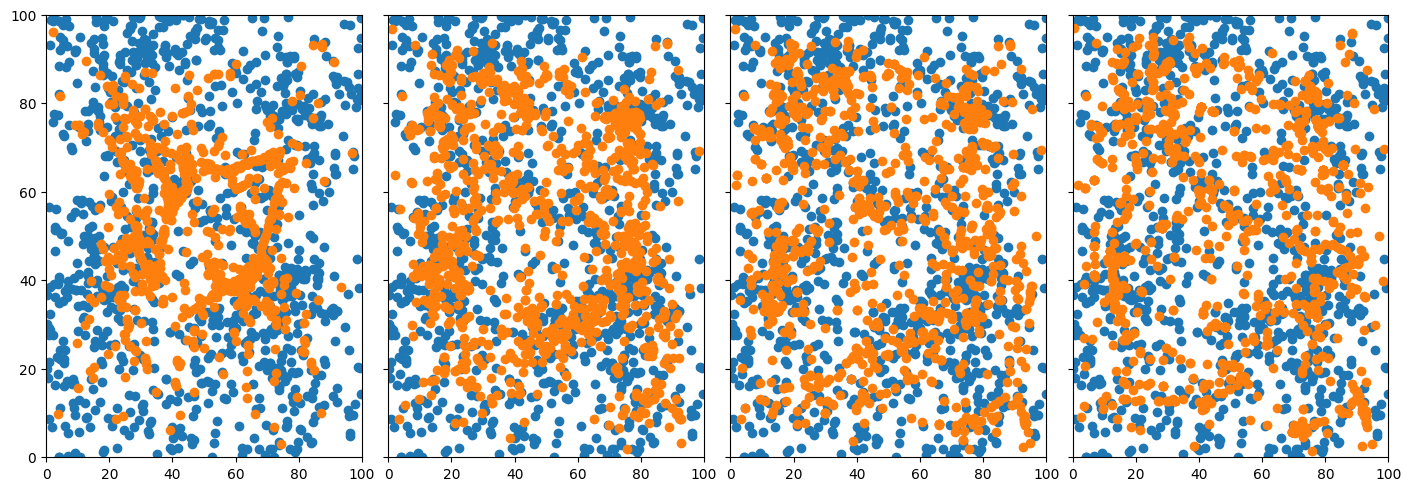

In [141]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, layout="constrained", sharex=True, sharey=True)

ax0.scatter(random_ancestors["true_location_0"], random_ancestors["true_location_1"])
ax0.scatter(random_ancestors["arg_estimated_location_0"], random_ancestors["arg_estimated_location_1"])
ax0.set_xlim(0,100)
ax0.set_ylim(0,100)

ax1.scatter(random_ancestors["true_location_0"], random_ancestors["true_location_1"])
ax1.scatter(random_ancestors["window_100_estimated_location_0"], random_ancestors["window_100_estimated_location_1"])

ax2.scatter(random_ancestors["true_location_0"], random_ancestors["true_location_1"])
ax2.scatter(random_ancestors["window_0_estimated_location_0"], random_ancestors["window_0_estimated_location_1"])

ax3.scatter(random_ancestors["true_location_0"], random_ancestors["true_location_1"])
ax3.scatter(random_ancestors["midpoint_estimated_location_0"], random_ancestors["midpoint_estimated_location_1"])

fig.set_figwidth(14)
plt.show()

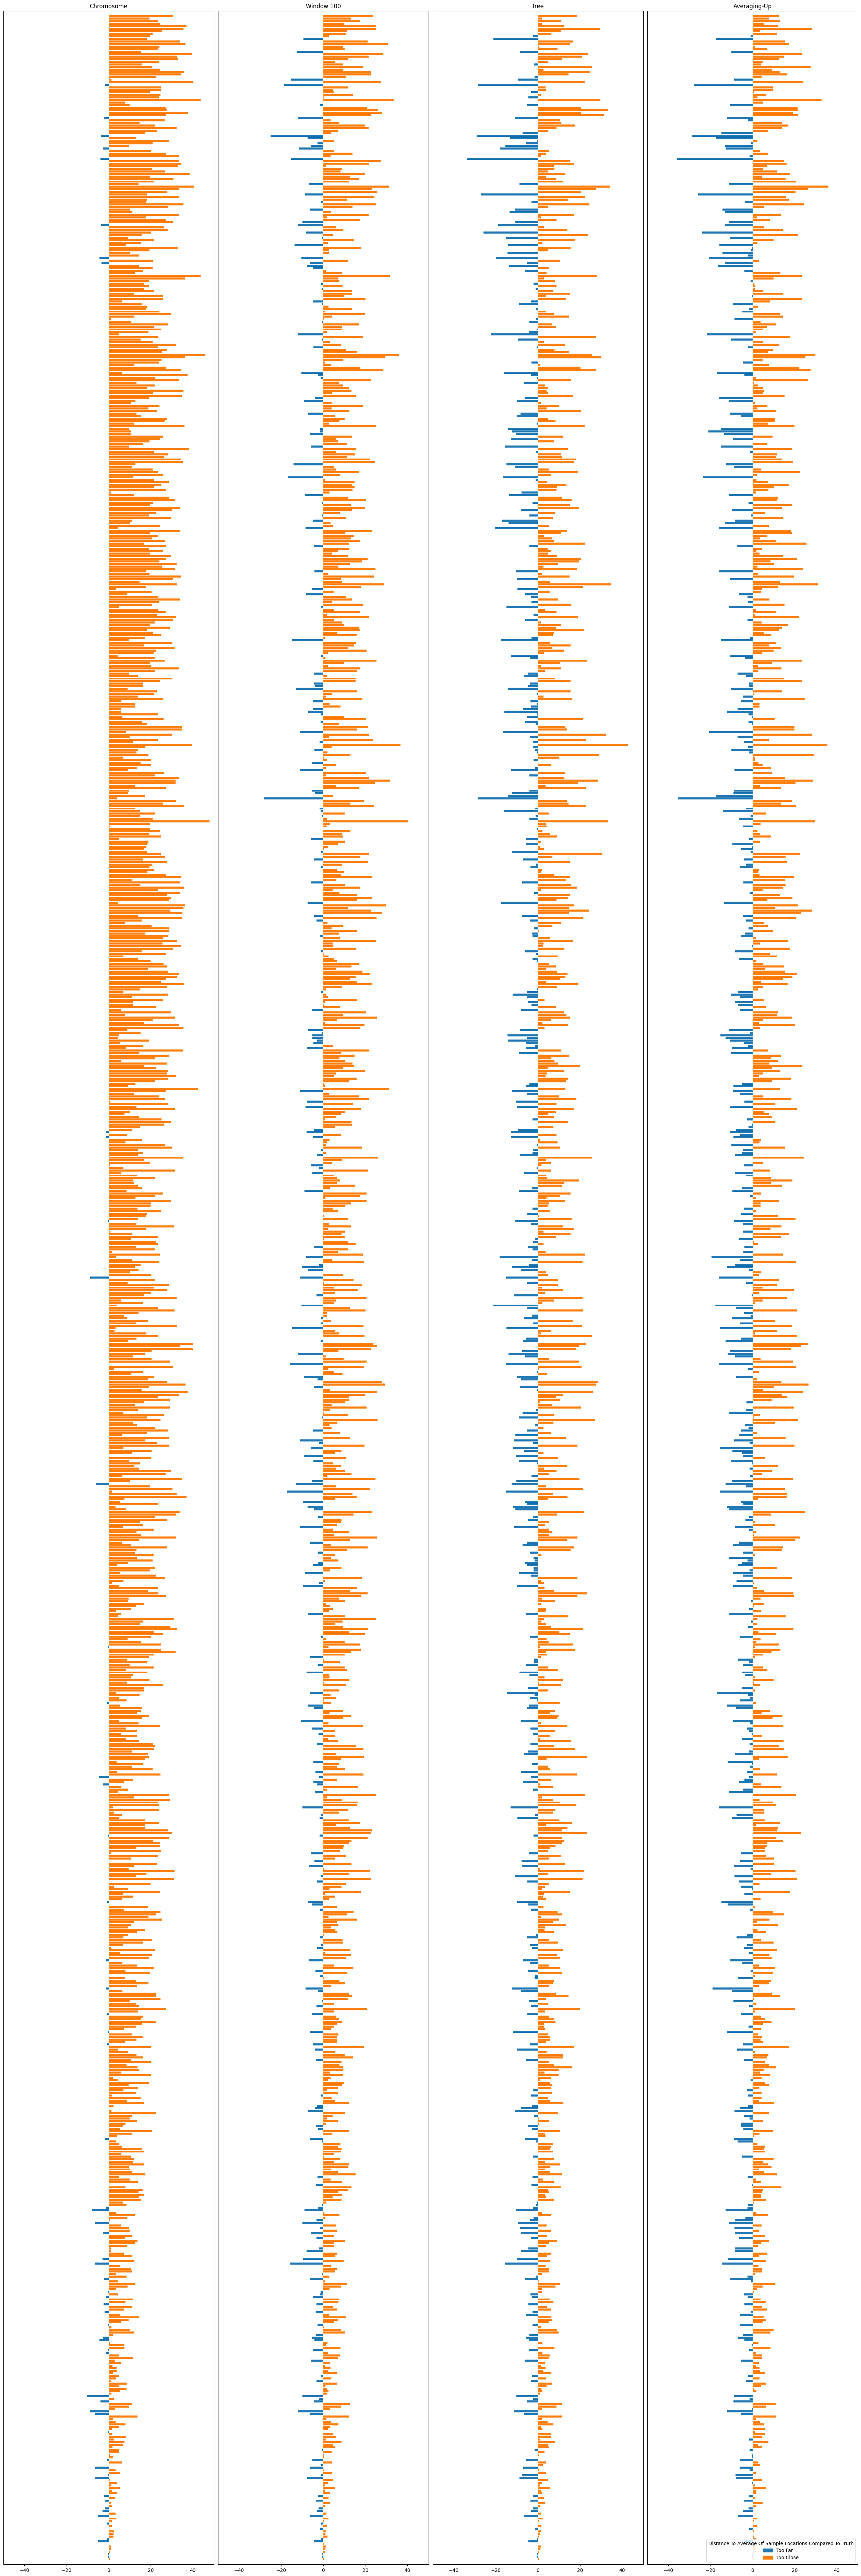

In [135]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

random_ancestors["arg_distance_to_center_difference"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) - np.sqrt(abs(random_ancestors["arg_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["arg_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["window_100_distance_to_center_difference"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) - np.sqrt(abs(random_ancestors["window_100_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_100_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["window_0_distance_to_center_difference"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) - np.sqrt(abs(random_ancestors["window_0_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_0_estimated_location_1"] - center_of_samples[1])**2)
random_ancestors["midpoint_distance_to_center_difference"] = np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) - np.sqrt(abs(random_ancestors["midpoint_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["midpoint_estimated_location_1"] - center_of_samples[1])**2)

random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["midpoint_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["midpoint_estimated_location_1"] - center_of_samples[1])**2), "midpoint_central"] = "#1f77b4"
random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) > np.sqrt(abs(random_ancestors["midpoint_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["midpoint_estimated_location_1"] - center_of_samples[1])**2), "midpoint_central"] = "#ff7f0e"

random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["arg_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["arg_estimated_location_1"] - center_of_samples[1])**2), "arg_central"] = "#1f77b4"
random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) > np.sqrt(abs(random_ancestors["arg_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["arg_estimated_location_1"] - center_of_samples[1])**2), "arg_central"] = "#ff7f0e"

random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["window_0_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_0_estimated_location_1"] - center_of_samples[1])**2), "window_0_central"] = "#1f77b4"
random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) > np.sqrt(abs(random_ancestors["window_0_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_0_estimated_location_1"] - center_of_samples[1])**2), "window_0_central"] = "#ff7f0e"

random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) <= np.sqrt(abs(random_ancestors["window_100_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_100_estimated_location_1"] - center_of_samples[1])**2), "window_100_central"] = "#1f77b4"
random_ancestors.loc[np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2) > np.sqrt(abs(random_ancestors["window_100_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_100_estimated_location_1"] - center_of_samples[1])**2), "window_100_central"] = "#ff7f0e"

to_plot = random_ancestors.sort_values("time")

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, layout="constrained", sharey=True)
ax0.barh(range(len(to_plot["arg_distance_to_center_difference"])), to_plot["arg_distance_to_center_difference"], color=to_plot["arg_central"], zorder=1)#, color=colors(to_plot["time"]/2000), zorder=1)
ax0.set_ylim(-1,len(to_plot["arg_distance_to_center_difference"])+1)
ax0.set_title("Chromosome")
ax1.barh(range(len(to_plot["window_100_distance_to_center_difference"])), to_plot["window_100_distance_to_center_difference"], color=to_plot["window_100_central"])#, color=colors(to_plot["time"]/2000))
ax1.set_title("Window 100")
ax2.barh(range(len(to_plot["window_0_distance_to_center_difference"])), to_plot["window_0_distance_to_center_difference"], color=to_plot["window_0_central"])#, color=colors(to_plot["time"]/2000))
ax2.set_title("Tree")
ax3.barh(range(len(to_plot["midpoint_distance_to_center_difference"])), to_plot["midpoint_distance_to_center_difference"], color=to_plot["midpoint_central"])#, color=colors(to_plot["time"]/2000))
ax3.set_title("Averaging-Up")
fig.set_figheight(75)
fig.set_figwidth(25)
plt.setp((ax0, ax1, ax2, ax3), xlim=(-50,50))
plt.yticks([])

patches = []
for i,n in enumerate(["Too Far", "Too Close"]):
    patches.append(mpatches.Patch(color=colors[i], label=n))
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend(patches)

plt.legend(title="Distance To Average Of Sample Locations Compared To Truth", handles=handles, loc="lower right")

plt.savefig("subfigures/S_LocationBiasBars.svg")
plt.show()


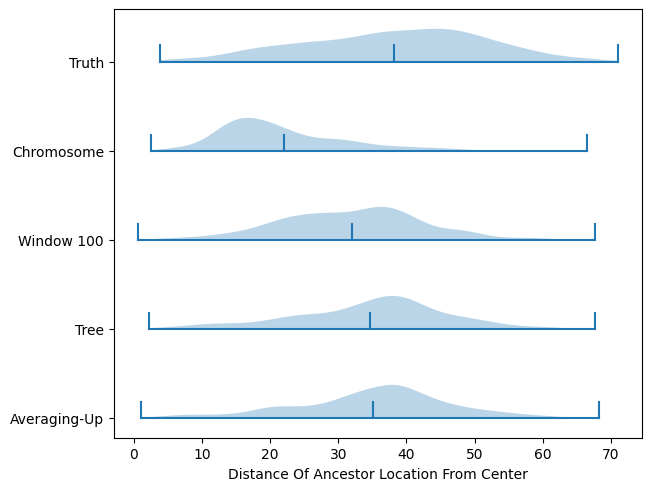

In [32]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, layout="constrained")

ax0.violinplot([
    np.sqrt(abs(random_ancestors["midpoint_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["midpoint_estimated_location_1"] - center_of_samples[1])**2),
    np.sqrt(abs(random_ancestors["window_0_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_0_estimated_location_1"] - center_of_samples[1])**2),
    np.sqrt(abs(random_ancestors["window_100_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["window_100_estimated_location_1"] - center_of_samples[1])**2),
    np.sqrt(abs(random_ancestors["arg_estimated_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["arg_estimated_location_1"] - center_of_samples[1])**2),
    np.sqrt(abs(random_ancestors["true_location_0"] - center_of_samples[0])**2 + abs(random_ancestors["true_location_1"] - center_of_samples[1])**2)
], showmeans=True, vert=False, side="high", widths=0.75)

#ax0.contour(random_ancestors["true_location_0"], random_ancestors["true_location_1"])
#ax0.contour(random_ancestors["arg_estimated_location_0"], random_ancestors["arg_estimated_location_1"])
plt.yticks([5,4,3,2,1], ["Truth", "Chromosome", "Window 100", "Tree", "Averaging-Up"])
plt.xlabel("Distance Of Ancestor Location From Center")
plt.show()

We do not see a bias in error when scanning across the genome.

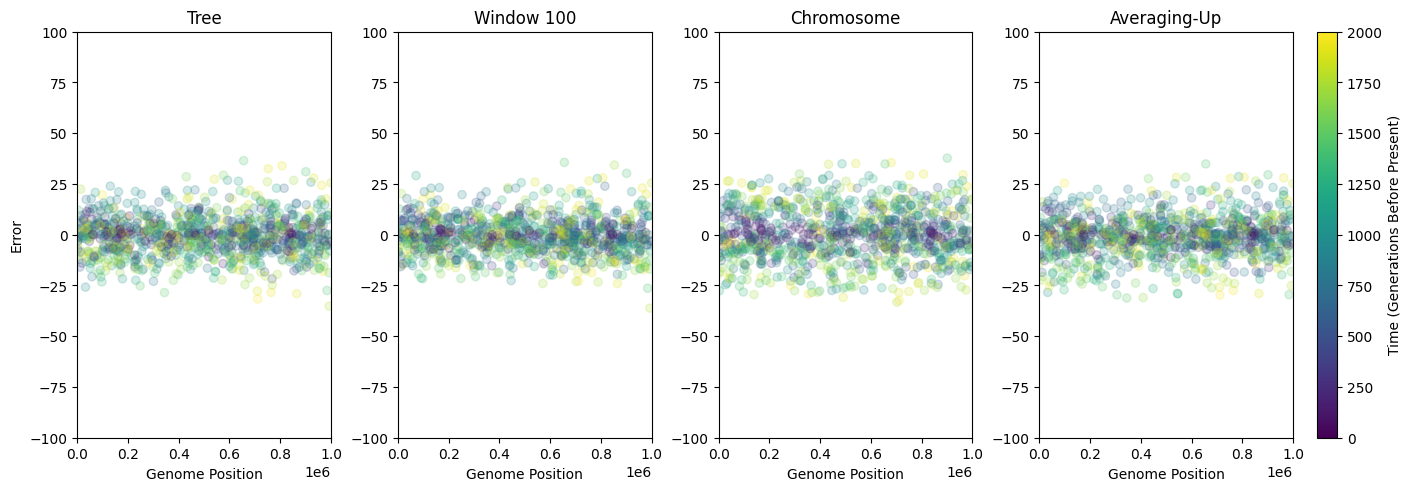

In [7]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=4, layout="constrained")

ax0.scatter(random_ancestors["genome_position"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_xlim([0, 1000000])
ax0.set_ylim([-100, 100])
ax0.set_title("Tree")
ax0.set_ylabel("Error")
ax0.set_xlabel("Genome Position")
ax1.scatter(random_ancestors["genome_position"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_xlim([0, 1000000])
ax1.set_ylim([-100, 100])
ax1.set_title("Window 100")
ax1.set_xlabel("Genome Position")
ax2.scatter(random_ancestors["genome_position"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_xlim([0, 1000000])
ax2.set_ylim([-100, 100])
ax2.set_title("Chromosome")
ax2.set_xlabel("Genome Position")
midpoint = ax3.scatter(random_ancestors["genome_position"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_xlim([0, 1000000])
ax3.set_ylim([-100, 100])
ax3.set_title("Averaging-Up")
ax3.set_xlabel("Genome Position")

colorbar = fig.colorbar(midpoint, ax=ax3, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)
plt.savefig("subfigures/S_GenomePositionBias.svg")
plt.show()

### Coverage

The following section looks at how well the confidence intervals capture the true locations of the ancestors. As we increase the number of standard deviations out from the estimated location, we should capture more of the true locations. If our dispersal rate is the correct size (which it should be because we are using the theoretical effective dispersal rate), the coverage should fall very close to the expectation line.

In [8]:
std_arg = np.sqrt(random_ancestors["arg_variance_in_estimated_location_0"])
std_0 = np.sqrt(random_ancestors["window_0_variance_in_estimated_location_0"])
#std_10 = np.sqrt(random_ancestors["window_10_variance_in_estimated_location_0"])
std_100 = np.sqrt(random_ancestors["window_100_variance_in_estimated_location_0"])

expected_zs = []
expected_percent_within = []
percent_within_arg = []
percent_within_w0 = []
#percent_within_w10 = []
percent_within_w100 = []
for i in range(0,300):
    value = st.norm.cdf(i/100)
    expected_zs.append(i/100)
    expected_percent_within.append(value - (1-value))
    percent_within_arg.append(sum(random_ancestors["arg_abs_error_0"] <= std_arg*(i/100))/len(random_ancestors))
    percent_within_w0.append(sum(random_ancestors["window_0_abs_error_0"] <= std_0*(i/100))/len(random_ancestors))
    #percent_within_w10.append(sum(random_ancestors["window_10_abs_error_0"] <= std_10*(i/100))/len(random_ancestors))
    percent_within_w100.append(sum(random_ancestors["window_100_abs_error_0"] <= std_100*(i/100))/len(random_ancestors))

/opt/anaconda3/envs/sparg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


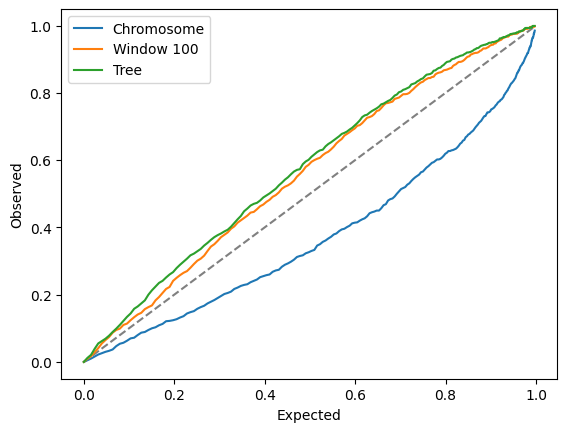

In [9]:
plt.plot(expected_percent_within, expected_percent_within, color="gray", linestyle="dashed")
plt.plot(expected_percent_within, percent_within_arg, label="Chromosome")
#plt.plot(expected_percent_within, percent_within_w10, label="W_10")
plt.plot(expected_percent_within, percent_within_w100, label="Window 100")
plt.plot(expected_percent_within, percent_within_w0, label="Tree")
plt.xlabel("Expected")
plt.ylabel("Observed")
plt.legend()
plt.savefig("subfigures/Fig6_Coverage.svg")
plt.show()